## Language Translator

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing as pre, pipeline as pl
from sklearn import model_selection as ms, metrics

import nltk
from nltk.corpus import comtrans

import gensim

from tensorflow import keras
from tensorflow.keras import models, layers

from bobs import learn, plots
import transformers

/opt/conda/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


From `nltk` we can download translated sentences between different languages. You can see the example between **English and French** below but feel free to try different combination as well.

In [2]:
nltk.download('comtrans')

[nltk_data] Downloading package comtrans to /home/jovyan/nltk_data...
[nltk_data]   Package comtrans is already up-to-date!


True

In [3]:
en_fr = comtrans.aligned_sents('alignment-en-fr.txt')

### Exploration

In [4]:
[(en_fr[1].words[en], en_fr[1].mots[fr]) for en, fr in en_fr[1].alignment]

[('a', 'de'),
 ('period', 'vacances'),
 ('once', 'renouvelle'),
 ('1999', 'dernier'),
 ('.', '.'),
 ('festive', 'tous'),
 ('adjourned', 'qui'),
 ('Parliament', 'Parlement'),
 ('resumed', 'reprise'),
 ('you', 'vous'),
 ('adjourned', 'interrompue'),
 ('I', 'je'),
 ('on', 'le'),
 ('pleasant', 'bonnes'),
 ('European', 'européen'),
 ('the', 'du'),
 ('would', 'vous'),
 ('the', 'la'),
 ('hope', 'espérant'),
 ('festive', 'vux'),
 ('adjourned', 'été'),
 ('festive', 'renouvelle'),
 ('Friday', 'vendredi'),
 ('like', 'renouvelle'),
 ('festive', 'vacances'),
 ('you', 'avez'),
 ('that', 'que'),
 ('17', '17'),
 ('in', 'en'),
 ('session', 'session'),
 ('again', 'renouvelle'),
 ('of', 'du'),
 ('pleasant', 'renouvelle'),
 ('I', 'Je'),
 ('adjourned', 'avait'),
 ('declare', 'déclare'),
 ('festive', 'mes'),
 ('enjoyed', 'passé'),
 ('December', 'décembre'),
 ('and', 'et')]

In [5]:
" ".join(en_fr[1].words)

'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period .'

In [6]:
" ".join(en_fr[1].mots)

'Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances .'

In [7]:
len(en_fr)

33334

### Train-test

In [8]:
en_fr_train, en_fr_test = ms.train_test_split(en_fr, random_state=42)

In [9]:
len(en_fr_train)

25000

### Word embedding

In [10]:
def en_words(sents):
    return [sent.words for sent in sents]

def fr_words(sents):
    return [sent.mots for sent in sents]

In [11]:
def make_wv_en():
    wv_en = gensim.models.Word2Vec(
        sentences=en_words(en_fr_train),
        workers=8,
    )
    return wv_en.wv

In [12]:
def make_wv_fr():
    wv_fr = gensim.models.Word2Vec(
        sentences=fr_words(en_fr_train),
        workers=8,
    )
    return wv_fr.wv

In [13]:
wv_en = learn.load_or_train(
    'wv_en.model', make_wv_en, method='keyedvectors'
)

In [14]:
wv_fr = learn.load_or_train(
    'wv_fr.model', make_wv_fr, method='keyedvectors'
)

In [15]:
en_train = en_words(en_fr_train)
fr_train = fr_words(en_fr_train)
en_test = en_words(en_fr_test)
fr_test = fr_words(en_fr_test)

### Preprocessing

In [16]:
en_lens = pd.DataFrame({'length': [len(sent) for sent in en_train]})
fr_lens = pd.DataFrame({'length': [len(sent) for sent in fr_train]})

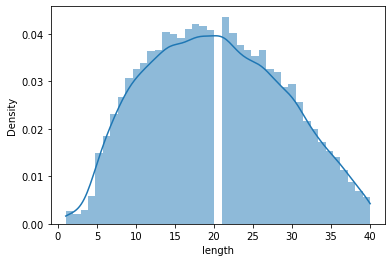

In [17]:
plots.distplot(en_lens, 'length')

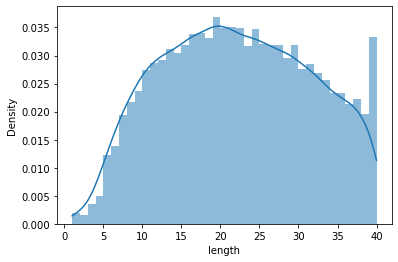

In [18]:
plots.distplot(fr_lens, 'length')

In [19]:
tr_en_vectors = transformers.Word2VecTransformer(wv_en)
tr_fr_vectors = transformers.Word2VecTransformer(wv_fr)

In [20]:
padder = pre.FunctionTransformer(transformers.pad)

In [21]:
en_pipeline = pl.Pipeline([
    ('en_vectors', tr_en_vectors),
    ('padder', padder),
])

In [22]:
fr_pipeline = pl.Pipeline([
    ('fr_vectors', tr_fr_vectors),
    ('padder', padder),
])

In [23]:
#test_pipeline.transform(en_train[:5]).shape

In [24]:
en_train_vecs = en_pipeline.fit_transform(en_train)
fr_train_vecs = en_pipeline.fit_transform(fr_train)

In [25]:
en_f = np.sqrt((en_train_vecs ** 2).sum(axis=2)).flatten()
en_f[np.nonzero(en_f)].min()

0.14929688630021

In [26]:
fr_f = np.sqrt((fr_train_vecs ** 2).sum(axis=2)).flatten()
fr_f[np.nonzero(fr_f)].min()

0.1557485773604513

### LSTM

In [27]:
def make_simple_lstm_fr_to_en():
    model = models.Sequential(name='simple_lstm_fr_to_en')
    model.add(layers.Input(fr_train_vecs.shape[1:], name='input'))
    model.add(layers.LSTM(units=50, return_sequences=True, name='lstm1'))
    model.add(layers.Dropout(0.2, name='dropout1'))
    model.add(layers.LSTM(units=50, return_sequences=True, name='lstm2'))
    model.add(layers.Dropout(0.2, name='dropout2'))
    model.add(layers.Dense(100, activation='relu', name='dense1'))
    model.add(layers.Dense(100, activation='relu', name='dense2'))
    model.add(layers.Dense(100, activation='relu', name='dense3'))
    model.add(layers.Dense(100, activation='tanh', name='output'))
    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

In [28]:
make_simple_lstm_fr_to_en().summary()

Model: "simple_lstm_fr_to_en"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 40, 50)            30200     
_________________________________________________________________
dropout1 (Dropout)           (None, 40, 50)            0         
_________________________________________________________________
lstm2 (LSTM)                 (None, 40, 50)            20200     
_________________________________________________________________
dropout2 (Dropout)           (None, 40, 50)            0         
_________________________________________________________________
dense1 (Dense)               (None, 40, 100)           5100      
_________________________________________________________________
dense2 (Dense)               (None, 40, 100)           10100     
_________________________________________________________________
dense3 (Dense)               (None, 40, 100)  

In [29]:
def train_simple_lstm_fr_to_en():
    model = make_simple_lstm_fr_to_en()
    model.fit(fr_train_vecs, en_train_vecs, epochs=20, batch_size=512)
    return model

In [30]:
simple_lstm_fr_to_en = learn.load_or_train(
    'simple_lstm_fr_to_en',
    train_simple_lstm_fr_to_en,
    method='tensorflow',
)

In [31]:
def translate_fr_en(model, sentence):
    return " ".join(
        tr_en_vectors.inverse_transform(
            model.predict(
                fr_pipeline.transform([sentence.split()])
            )
        )[0]
    )

In [33]:
translate_fr_en(simple_lstm_fr_to_en, 'Je déclare reprise la session.')

'The approved Budget Time approved Budget paragraph PT PT preference preference resume A A An An An'